# IBM watsonx.governance Agents Evaluation Studio - Tracking and Comparing Quality of LangFlow based applications

## Scenario Overview

Consider a development team building a RAG based chatbot—using LangFlow Vector RAG Flow—for their application. The underlying model powering the system is, say, OpenAI.

During the development phase, the team evaluates the chatbot by asking a set of questions. For each question:

    The relevant context is retrieved,
    A response is generated by the LangFlow powered chatbot, and
    A ground truth answer (as it can be available during development) is used for comparison.

In addition to this test data set, the team has prepared a validation set of questions, which are also run against the application.

To assess the quality of the responses, the team uses the IBM watsonx.governance SDK to compute:

    RAG-specific metrics such as answer relevance, answer similarity
    Readability metrics of the generated responses

Both the development and validation sets have corresponding computed metrics.

To track these evaluations, the team uses Evaluation Studio in watsonx.governance:

    An AI Experiment is created.
    Both evaluation runs (development and validation) are logged under this experiment.
    The experiment runs are then compared using AI Evaluation.
    Finally, the results and comparisons are visualized through the Evaluation Studio UI for further insights.

This notebook walks through this end-to-end workflow.

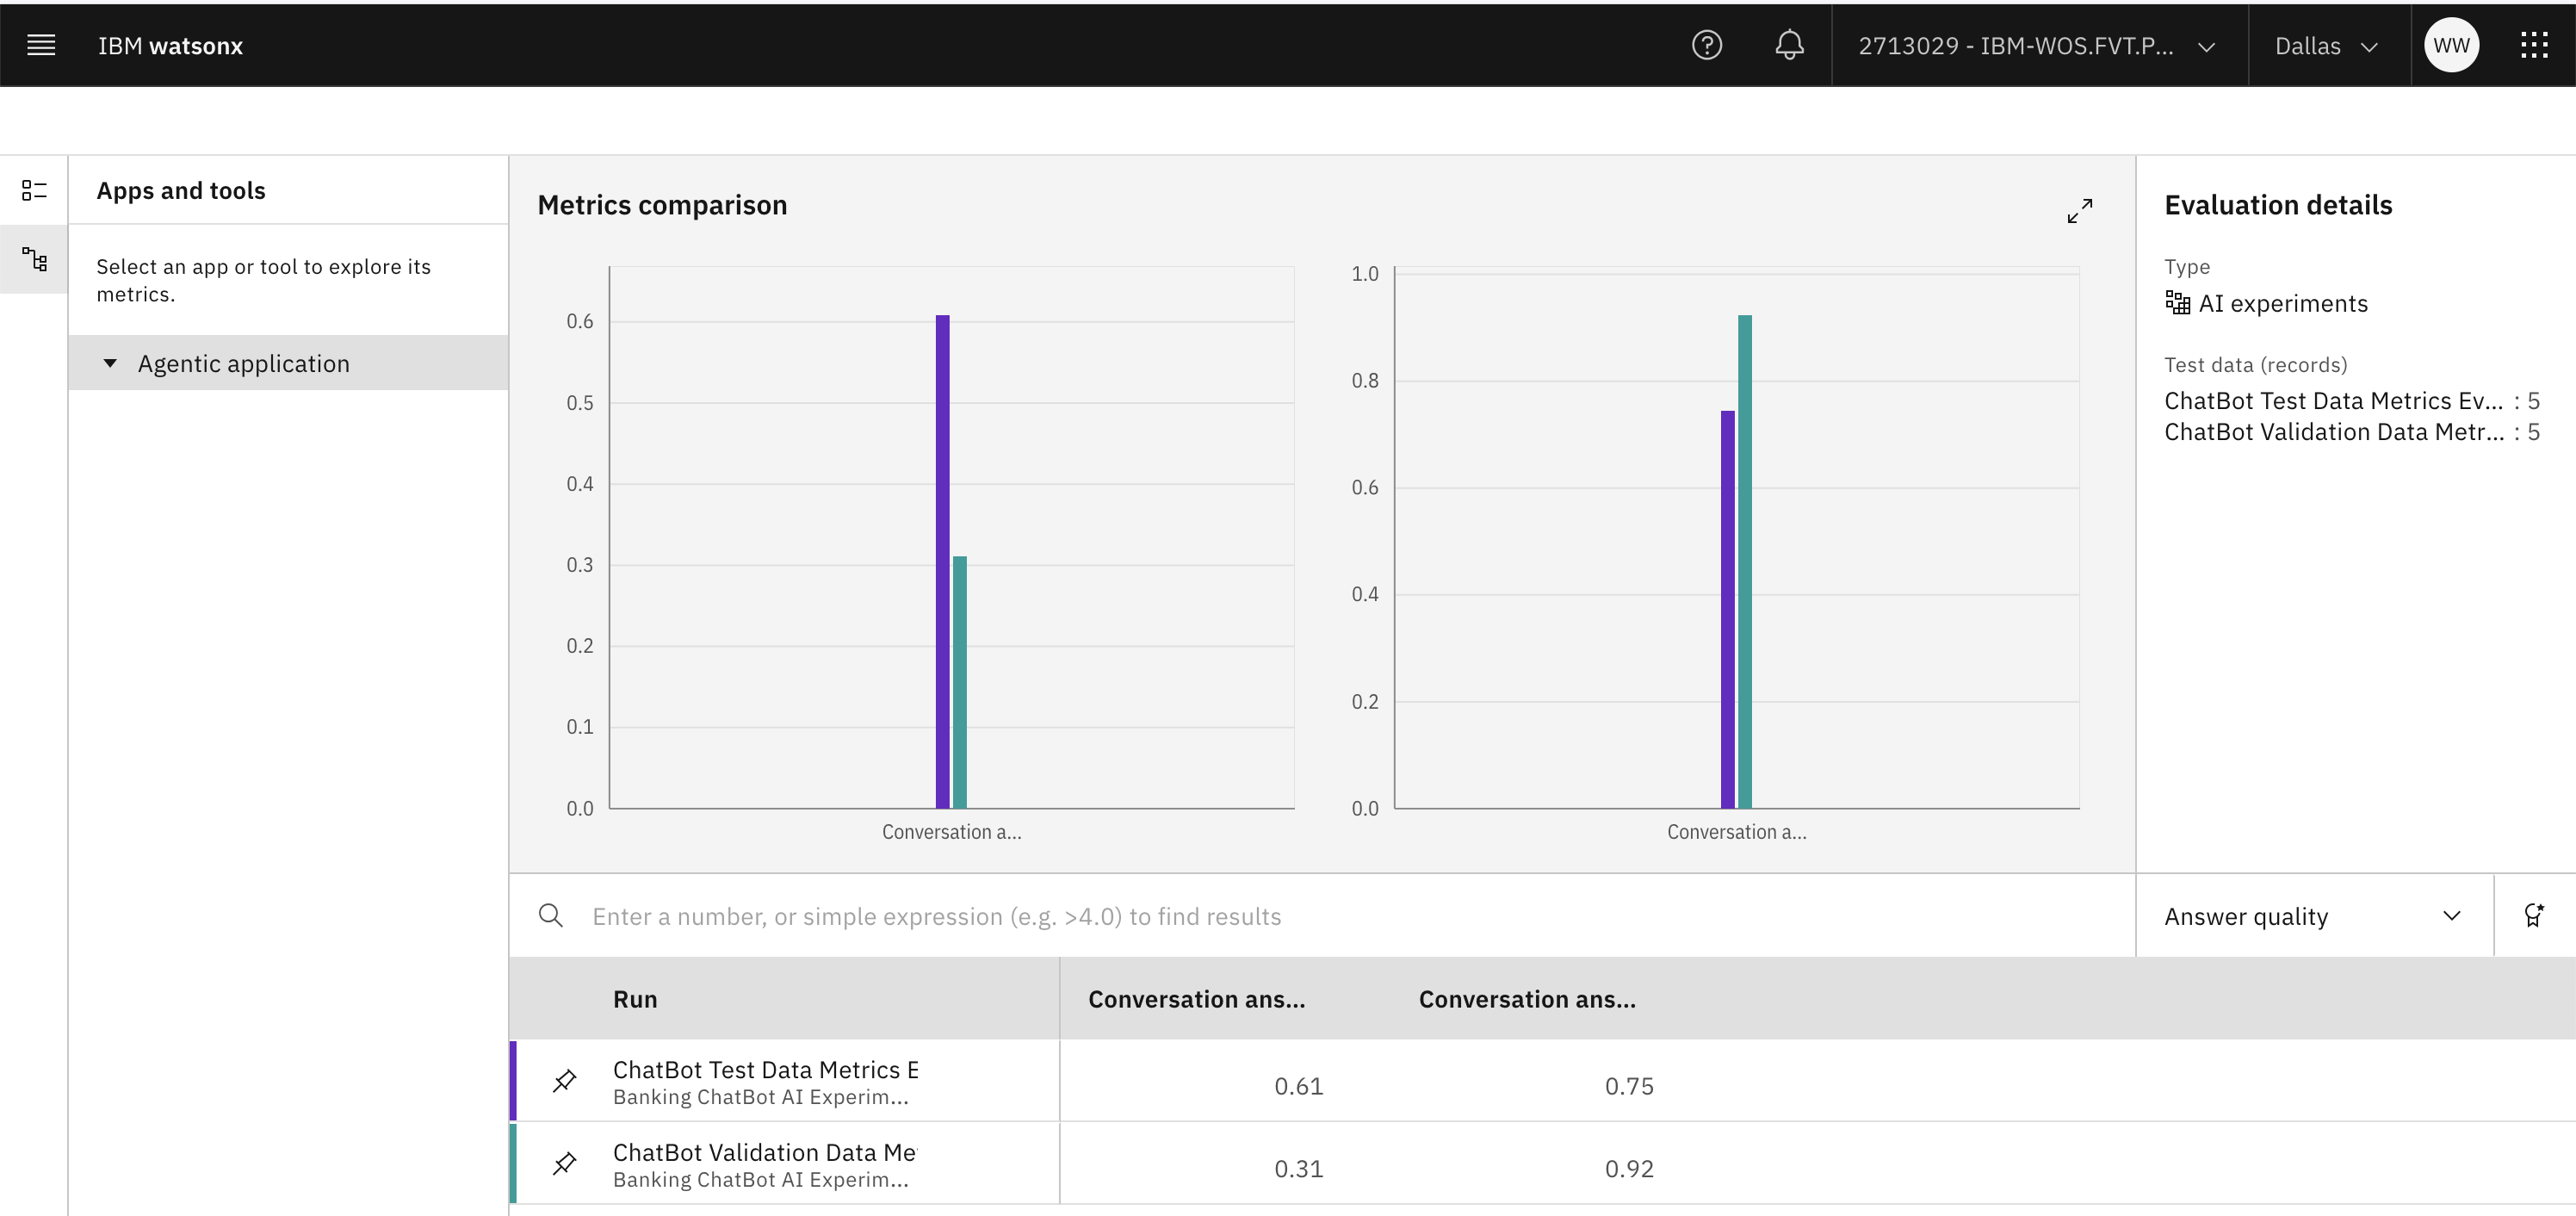

#### Required pip installations

In [ ]:
%pip install "ibm-watsonx-gov[agentic]" | tail -n 1

In [19]:
import warnings
warnings.filterwarnings("ignore")

### LangFlow Credentials and LangFlow application endpoint

In [ ]:
# API Configuration
LANGFLOW_API_KEY = "[Your LangFlow API Key]"
url = "[Your LangFlow Endpoint]"  # The complete API endpoint URL for this flow    

# Request headers
headers = {
    "Content-Type": "application/json",
    "x-api-key": LANGFLOW_API_KEY  # Authentication key from environment variable
}

### For a given question, run the LangFlow application to get the generated answer

In [115]:
import requests
import os

def chat_with_langflow(question):
    # Request payload configuration
    payload = {
        "output_type": "chat",
        "input_type": "chat",
        "input_value": question
    }

    try:
        # Send API request
        response = requests.request("POST", url, json=payload, headers=headers)
        response.raise_for_status()  # Raise exception for bad status codes
    
        # Print response
        response_data = response.json()
        answer = response_data["outputs"][0]["outputs"][0]["results"]["message"]["text"]
        return answer
    except requests.exceptions.RequestException as e:
        print(f"Error making API request: {e}")
        return e
    except ValueError as e:
        print(f"Error parsing response: {e}")
        return e

### Quick run of a question

In [139]:
question = "I am unable to add products to my wishlist"
answer = chat_with_langflow(question)
answer

'Please try adding your product again to the wishlist. If the issue persists, please mail your queries to support@OpenFinance.co.in.'

### Start the watsonx.governance evaluation on the question, generated answer and the ground truth answer

#### Credentials to run watsonx.gov SDK and AI Experiments

In [ ]:
WATSONX_APIKEY = "[Your IBM Cloud API Key]"
WATSONX_PROJECT_ID = "[Your IBM watsonx Project Id]"
WXG_SERVICE_INSTANCE_ID = '[Your IBM watsonx.governance Instance Id]'

### Utility method to add the langflow response to the original dataframe (containing question and ground_truth)

In [132]:
import pandas as pd
import numpy as np
import time
def enrich_with_langflow(df):
    generated_answers = []
    for q in df["question"]:
        try:
            # Sleep before each API call - even for the first API call.
            time.sleep(2)
            print('question:', q)
            answer = chat_with_langflow(q)  # Call the LangFlow flow with the question
            print('answer:', answer)
            print('\n')
        except Exception as e:
            answer = "Unable to get the answer from LangFlow."
        generated_answers.append(answer)
    df["langflow_generated_answer"] = generated_answers
    return df

## Test data

In [137]:
# Create two sets of 5 Q&A pairs based on the extracted FAQ content
set1 = [
    {
        "question": "My beneficiary's account is not yet credited with the amount I have transferred. What do I do?",
        "ground_truth": "Please use 'raise a query' option available in the support section in the app using your \
        transaction reference number. You could also track your query from time to time."
    },
    {
        "question": "I could not find 'X' Merchant in OMP?",
        "ground_truth": "We thank you for your feedback. The existing Merchants on OPEN FINANCE platform offer wide variety \
        of products. You would find more merchants offering their products on our OMP soon."
    },
    {
        "question": "If a transaction is not credited to the beneficiary account, does the remitter get back the money?",
        "ground_truth": "Yes. If the beneficiary's bank is unable to credit the beneficiary's account for any reason, the \
        former will return the money to the remitting bank within 2 hours. Once the amount is received\
        by the remitting bank, it is credited to the remitter's account by the branch concerned."
    },
    {
        "question": "What should be done if customer does not find old transaction on the screen?",
        "ground_truth": "Please use smart search option for old transaction using date /amount/tag etc."
    },
    {
        "question": "What should be done if customer does not find transaction older than 3 years?",
        "ground_truth": "Please contact branch and put request for older transaction Or your request will be taken by us\
        and will be forwarded to our specialized team/Branch for resolution"
    }
]

# For each question, call the langflow application to get the answer and add it back to the same dataframe.
banking_rag_chatbot_qna_1 = pd.DataFrame(set1)
banking_rag_chatbot_qna_1 = enrich_with_langflow(banking_rag_chatbot_qna_1)
banking_rag_chatbot_qna_1

question: My beneficiary's account is not yet credited with the amount I have transferred. What do I do?
answer: If your beneficiary's account has not yet been credited with the amount you transferred, it is possible that there was an issue with the transaction. First, check to ensure that the beneficiary details you entered were correct. If the beneficiary's bank is unable to credit their account for any reason, the funds will typically be returned to your account within 2 hours. 

If you do not see the transaction in your account, you can use the smart search option in your app to look for the old transaction using the date, amount, or tags. If the issue persists, consider reaching out to your bank's customer support for further assistance.


question: I could not find 'X' Merchant in OMP?
answer: We thank you for your feedback. The existing Merchants on the OPEN FINANCE platform offer a wide variety of products. You will find more merchants offering their products on our OMP soon.



,question,ground_truth,langflow_generated_answer
0,My beneficiary's account is not yet credited w...,Please use 'raise a query' option available in...,If your beneficiary's account has not yet been...
1,I could not find 'X' Merchant in OMP?,We thank you for your feedback. The existing M...,We thank you for your feedback. The existing M...
2,If a transaction is not credited to the benefi...,Yes. If the beneficiary's bank is unable to cr...,"Yes, if the beneficiary's bank is unable to cr..."
3,What should be done if customer does not find ...,Please use smart search option for old transac...,If the customer does not find the old transact...
4,What should be done if customer does not find ...,Please contact branch and put request for olde...,If the customer does not find a transaction ol...


## Validation data

In [140]:
set2 = [
    {
        "question": "What is the next step after raising the query?",
        "ground_truth": "Dear Customer, please select Track Query option to get the status update and reply to your query"
    },
    {
        "question": "How to track the query after it has been raised?",
        "ground_truth": "Dear Customer, you can smart search by using your details for tracking the query"
    },
    {
        "question": "I am unable to add products to my wishlist",
        "ground_truth": "Please try adding your product again to the wishlist. If the issue persists, please mail your queries to \
        support@Openfinance.co.in."
    },
    {
        "question": "The changes I have made in my profile are not being saved",
        "ground_truth": "User will be asked about the fields that have been modified and a query is raised to address this issue"
    },
    {
        "question": "I am unable to view the modified/changed information in my profile",
        "ground_truth": "User will be asked about the fields that have been modified and a query is raised to address this issue"
    }
]

# Convert to DataFrames
banking_rag_chatbot_qna_2 = pd.DataFrame(set2)
banking_rag_chatbot_qna_2 = enrich_with_langflow(banking_rag_chatbot_qna_2)
banking_rag_chatbot_qna_2

question: What is the next step after raising the query?
answer: Dear Customer, please select the Track Query option to get the status update and reply to your query.


question: How to track the query after it has been raised?
answer: To track the query after it has been raised, you can use the smart search feature by entering your details to find the status of your query. Additionally, you can select the "Track Query" option to get updates and replies regarding your query.


question: I am unable to add products to my wishlist
answer: Please try adding your product again to the wishlist. If the issue persists, please mail your queries to support@OpenFinance.co.in.


question: The changes I have made in my profile are not being saved
answer: User will be asked about the fields that have been modified, and a query is raised to address this issue.


question: I am unable to view the modified/changed information in my profile
answer: User will be asked about the fields that have been mod

,question,ground_truth,langflow_generated_answer
0,What is the next step after raising the query?,"Dear Customer, please select Track Query optio...","Dear Customer, please select the Track Query o..."
1,How to track the query after it has been raised?,"Dear Customer, you can smart search by using y...","To track the query after it has been raised, y..."
2,I am unable to add products to my wishlist,Please try adding your product again to the wi...,Please try adding your product again to the wi...
3,The changes I have made in my profile are not ...,User will be asked about the fields that have ...,User will be asked about the fields that have ...
4,I am unable to view the modified/changed infor...,User will be asked about the fields that have ...,User will be asked about the fields that have ...


In [161]:
from ibm_watsonx_gov.entities.credentials import Credentials
credentials = Credentials(api_key=WATSONX_APIKEY,
                          service_instance_id=WXG_SERVICE_INSTANCE_ID)

In [162]:
from ibm_watsonx_gov.ai_experiments.ai_experiments_client import AIExperimentsClient
from ibm_watsonx_gov.entities.ai_experiment import AIExperimentRun, AIExperiment
from ibm_watsonx_gov.clients.api_client import APIClient

# Initializing APIClient
api_client = APIClient(credentials=credentials)

### Configurations

* Define the GenAIConfiguration, specifying which fields represent the question, context, the response, and the grount truth
    
* Configure the use of RAG evaluation metrics, which require the input question, retrieved context, generated response, and the ground truth answer. (Note: Only a subset of available metrics is shown here. For the complete list, refer to the watsonx.governance documentation - https://ibm.github.io/ibm-watsonx-gov/index.html)



In [163]:
from ibm_watsonx_gov.config import GenAIConfiguration
from ibm_watsonx_gov.metrics import AnswerRelevanceMetric
from ibm_watsonx_gov.metrics import AnswerSimilarityMetric
from ibm_watsonx_gov.metrics import TextGradeLevelMetric
from ibm_watsonx_gov.metrics import TextReadingEaseMetric
from ibm_watsonx_gov.entities.enums import TaskType, MetricGroup

config = GenAIConfiguration(
    input_fields=["question"],
    context_fields=[],
    output_fields=["langflow_generated_answer"],
    reference_fields=["ground_truth"]
)

metrics = [
    AnswerRelevanceMetric(),
    AnswerSimilarityMetric(),
    TextGradeLevelMetric(),
    TextReadingEaseMetric(),
]

### Evaluate the Metrics

* Create MetricsEvaluator
* Evaluate the metrics against the data produced from the underlying prompt or Agent

In [164]:
from ibm_watsonx_gov.clients.api_client import APIClient
from ibm_watsonx_gov.evaluators import MetricsEvaluator

evaluator = MetricsEvaluator(
    api_client=APIClient(credentials=credentials),
    configuration=config,
)

## Evaluate on Test Data

In [165]:
evaluation_results_1 = evaluator.evaluate(
    data=banking_rag_chatbot_qna_1,
    metrics=metrics
)
evaluation_results_df_1 = evaluation_results_1.to_df()
evaluation_results_df_1

,answer_relevance.token_recall,answer_similarity.token_recall,text_grade_level.flesch_kincaid_grade,text_reading_ease.flesch_reading_ease
0,0.625000,0.461538,11.207413,53.539193
1,0.250000,0.965517,6.638750,66.464583
2,0.538462,0.846154,13.113889,41.117500
3,0.769231,0.750000,13.370909,57.976364
4,0.857143,0.703704,11.336522,54.750870


## Evaluate on Validation Data

In [166]:
evaluation_results_2 = evaluator.evaluate(
    data=banking_rag_chatbot_qna_2,
    metrics=metrics
)
evaluation_results_df_2 = evaluation_results_2.to_df()
evaluation_results_df_2

,answer_relevance.token_recall,answer_similarity.token_recall,text_grade_level.flesch_kincaid_grade,text_reading_ease.flesch_reading_ease
0,0.142857,1.000000,9.130000,61.665000
1,0.888889,0.615385,10.083372,61.063663
2,0.333333,1.000000,7.988684,54.708289
3,0.090909,1.000000,8.140000,72.325000
4,0.100000,1.000000,8.140000,72.325000


#### Utility method to average the individual record level metrics, and construct the Experiment Run object

In [167]:
def construct_run_metrics(df):
    import pandas as pd
    
    # Define column mapping and grouping
    metric_mapping = {
        'answer_relevance.token_recall': ('answer_relevance', 'answer_quality'),
        'answer_similarity.token_recall': ('answer_similarity', 'answer_quality'),
        'text_grade_level.flesch_kincaid_grade': ('text_grade_level', 'readability'),
        'text_reading_ease.flesch_reading_ease': ('text_reading_ease', 'readability')
    }
    
    # Aggregate and build JSON list
    run_metric_results = []
    for col, (new_name, group) in metric_mapping.items():
        if col in df.columns:
            avg_value = df[col].mean()
            count = df[col].count()
            run_metric_results.append({
                "name": new_name,
                "value": round(avg_value, 4),
                "group": group,
                "count": int(count)
            })

    agent_quality_monitor_results = {
        "AgentQualityMonitor": run_metric_results
    }

    #run_metric_results_df = pd.DataFrame(run_metric_results)
    return agent_quality_monitor_results

### Test Data Run metrics

In [168]:
# Preview result
run_1_metric_results = construct_run_metrics(evaluation_results_df_1)
run_1_metric_results

{'AgentQualityMonitor': [{'name': 'answer_relevance',
   'value': 0.608,
   'group': 'answer_quality',
   'count': 5},
  {'name': 'answer_similarity',
   'value': 0.7454,
   'group': 'answer_quality',
   'count': 5},
  {'name': 'text_grade_level',
   'value': 11.1335,
   'group': 'readability',
   'count': 5},
  {'name': 'text_reading_ease',
   'value': 54.7697,
   'group': 'readability',
   'count': 5}]}

### Validation Data Run Metrics

In [169]:
# Preview result
run_2_metric_results = construct_run_metrics(evaluation_results_df_2)
run_2_metric_results

{'AgentQualityMonitor': [{'name': 'answer_relevance',
   'value': 0.3112,
   'group': 'answer_quality',
   'count': 5},
  {'name': 'answer_similarity',
   'value': 0.9231,
   'group': 'answer_quality',
   'count': 5},
  {'name': 'text_grade_level',
   'value': 8.6964,
   'group': 'readability',
   'count': 5},
  {'name': 'text_reading_ease',
   'value': 64.4174,
   'group': 'readability',
   'count': 5}]}

## Creating AI Experiment asset to capture Metrics Evaluation Runs

In [170]:
# Creating AI Experiment asset
name = "Banking ChatBot AI Experiment"
description = "Evaluation of a RAG-based chatbot for common banking queries, using manually curated test cases across account services, loans, cards, digital banking, and UPI. Each case includes the user question, retrieved context, model answer, and human-verified ground truth for quality benchmarking."

ai_experiment_client = AIExperimentsClient(api_client=api_client, project_id=WATSONX_PROJECT_ID)
ai_experiment = AIExperiment(name=name, 
                             description=description,
                             component_type="agent",
                             component_name="Banking Chatbot Agent")

ai_experiment_asset = ai_experiment_client.create(ai_experiment)
ai_experiment_id = ai_experiment_asset.asset_id

Created AI experiment asset with id 40e89b10-aab3-4689-8f71-d880d88ee94c.



In [171]:
ai_experiment_asset.to_json()

{'container_id': 'e6f2109a-a22c-41cd-b69c-7fa65eb91add',
 'container_type': 'project',
 'container_name': '',
 'name': 'Banking ChatBot AI Experiment',
 'description': 'Evaluation of a RAG-based chatbot for common banking queries, using manually curated test cases across account services, loans, cards, digital banking, and UPI. Each case includes the user question, retrieved context, model answer, and human-verified ground truth for quality benchmarking.',
 'asset_type': 'ai_experiment',
 'created_at': '2025-09-16T17:03:40Z',
 'owner_id': 'IBMid-550002SR1C',
 'asset_id': '40e89b10-aab3-4689-8f71-d880d88ee94c',
 'creator_id': 'IBMid-550002SR1C',
 'component_id': '',
 'component_type': 'agent',
 'component_name': 'Banking Chatbot Agent',
 'runs': []}

## Create the Experiment Run for the Test Data

In [172]:
import uuid
experiment_run_1_details = AIExperimentRun(
                            run_id=str(uuid.uuid4()),
                            run_name="ChatBot Test Data Metrics Evaluation",
                            nodes=[],
                            duration=10
                        )
experiment_run_1_details

AIExperimentRun(run_id='28c796c4-4131-47ba-a939-7e4d7cc669cf', run_name='ChatBot Test Data Metrics Evaluation', created_at='', created_by='', test_data={}, tracked=False, id_deleted=False, attachment_id='', nodes=[], description='', source_name='', source_url='', duration=10, custom_tags=[], properties={}, agent_method_name='')

## Create the Experiment Run for the Validation Data

In [173]:
import uuid
experiment_run_2_details = AIExperimentRun(
                            run_id=str(uuid.uuid4()),
                            run_name="ChatBot Validation Data Metrics Evaluation",
                            nodes=[],
                            duration=10
                        )
experiment_run_2_details

AIExperimentRun(run_id='330a4d01-4abd-4391-902d-7a0274d8168d', run_name='ChatBot Validation Data Metrics Evaluation', created_at='', created_by='', test_data={}, tracked=False, id_deleted=False, attachment_id='', nodes=[], description='', source_name='', source_url='', duration=10, custom_tags=[], properties={}, agent_method_name='')

## Associate the Test Data Run metrics with the experiment

In [174]:
ai_experiment_client.update(
    ai_experiment_id=ai_experiment_id,
    experiment_run_details=experiment_run_1_details,
    evaluation_results=run_1_metric_results
)


Storing evaluation result for experiment run 28c796c4-4131-47ba-a939-7e4d7cc669cf of AI experiment 40e89b10-aab3-4689-8f71-d880d88ee94c.

Creating attachment for asset 40e89b10-aab3-4689-8f71-d880d88ee94c.

Successfully created attachment d8762301-801e-4005-b20a-6b8ca2f3715f for asset 40e89b10-aab3-4689-8f71-d880d88ee94c. Time taken: 3.9331929683685303.

Updated experiment run details for run ChatBot Test Data Metrics Evaluation of AI experiment 40e89b10-aab3-4689-8f71-d880d88ee94c.

Updated AI experiment asset 40e89b10-aab3-4689-8f71-d880d88ee94c.



AIExperiment(container_id='', container_type='', container_name='', name='AI Experiment for Agent', description='', asset_type='', created_at='', owner_id='', asset_id='', creator_id='', component_id='', component_type='agent', component_name='Banking Chatbot Agent', runs=[AIExperimentRun(run_id='28c796c4-4131-47ba-a939-7e4d7cc669cf', run_name='ChatBot Test Data Metrics Evaluation', created_at='2025-09-16T17:03:57Z', created_by='IBMid-550002SR1C', test_data={'total_rows': 5}, tracked=False, id_deleted=False, attachment_id='d8762301-801e-4005-b20a-6b8ca2f3715f', nodes=[], description='', source_name='', source_url='', duration=10, custom_tags=[], properties={}, agent_method_name='')])

## Associate the Validation Data Run metrics with the experiment

In [175]:
ai_experiment_client.update(
    ai_experiment_id=ai_experiment_id,
    experiment_run_details=experiment_run_2_details,
    evaluation_results=run_2_metric_results
)


Storing evaluation result for experiment run 330a4d01-4abd-4391-902d-7a0274d8168d of AI experiment 40e89b10-aab3-4689-8f71-d880d88ee94c.

Creating attachment for asset 40e89b10-aab3-4689-8f71-d880d88ee94c.

Successfully created attachment 85381397-028b-44e0-b58b-363b47b211c1 for asset 40e89b10-aab3-4689-8f71-d880d88ee94c. Time taken: 3.244459867477417.

Updated experiment run details for run ChatBot Validation Data Metrics Evaluation of AI experiment 40e89b10-aab3-4689-8f71-d880d88ee94c.

Updated AI experiment asset 40e89b10-aab3-4689-8f71-d880d88ee94c.



AIExperiment(container_id='', container_type='', container_name='', name='AI Experiment for Agent', description='', asset_type='', created_at='', owner_id='', asset_id='', creator_id='', component_id='', component_type='agent', component_name='Banking Chatbot Agent', runs=[AIExperimentRun(run_id='28c796c4-4131-47ba-a939-7e4d7cc669cf', run_name='ChatBot Test Data Metrics Evaluation', created_at='2025-09-16T17:03:57Z', created_by='IBMid-550002SR1C', test_data={'total_rows': 5}, tracked=False, id_deleted=False, attachment_id='d8762301-801e-4005-b20a-6b8ca2f3715f', nodes=[], description='', source_name='', source_url='', duration=10, custom_tags=[], properties={}, agent_method_name=''), AIExperimentRun(run_id='330a4d01-4abd-4391-902d-7a0274d8168d', run_name='ChatBot Validation Data Metrics Evaluation', created_at='2025-09-16T17:04:03Z', created_by='IBMid-550002SR1C', test_data={'total_rows': 5}, tracked=False, id_deleted=False, attachment_id='85381397-028b-44e0-b58b-363b47b211c1', nodes=[]

In [176]:
ai_experiment = ai_experiment_client.get(ai_experiment_id)
ai_experiment.to_json()

Retrieved AI experiment asset 40e89b10-aab3-4689-8f71-d880d88ee94c.



{'container_id': 'e6f2109a-a22c-41cd-b69c-7fa65eb91add',
 'container_type': 'project_id',
 'container_name': 'LangFlow Explorations',
 'name': 'Banking ChatBot AI Experiment',
 'description': 'Evaluation of a RAG-based chatbot for common banking queries, using manually curated test cases across account services, loans, cards, digital banking, and UPI. Each case includes the user question, retrieved context, model answer, and human-verified ground truth for quality benchmarking.',
 'asset_type': 'ai_experiment',
 'created_at': '2025-09-16T17:03:40Z',
 'owner_id': 'IBMid-550002SR1C',
 'asset_id': '40e89b10-aab3-4689-8f71-d880d88ee94c',
 'creator_id': 'IBMid-550002SR1C',
 'component_id': '',
 'component_type': 'agent',
 'component_name': 'Banking Chatbot Agent',
 'runs': [{'run_id': '28c796c4-4131-47ba-a939-7e4d7cc669cf',
   'run_name': 'ChatBot Test Data Metrics Evaluation',
   'created_at': '2025-09-16T17:03:57Z',
   'created_by': 'IBMid-550002SR1C',
   'test_data': {'total_rows': 5},
 

## Create the AI Evaluation Asset with the experiment that would create the watsonx.governance AI Evaluation Studio asset

In [177]:
from ibm_watsonx_gov.entities.ai_evaluation import EvaluationConfig
from ibm_watsonx_gov.entities.ai_evaluation import AIEvaluationAsset
ai_evaluation = ai_experiment_client.create_ai_evaluation_asset(    
    ai_experiment_ids=[ai_experiment_id],
    ai_evaluation_details=AIEvaluationAsset(
        name="Bank ChatBot Quality Evaluation Experiment",
        description="Bank ChatBot Quality Evaluation Experiment",
        evaluation_configuration=EvaluationConfig()
            ))

Retrieved AI experiment asset 40e89b10-aab3-4689-8f71-d880d88ee94c.

Created AI Evaluation asset with id a2dd45aa-53bf-4982-a4ab-6376bb53fdd1.


In [178]:
ai_evaluation.to_json()

{'container_id': 'e6f2109a-a22c-41cd-b69c-7fa65eb91add',
 'container_type': 'project',
 'container_name': 'Bank ChatBot Quality Evaluation Experiment',
 'name': 'Bank ChatBot Quality Evaluation Experiment',
 'description': 'Bank ChatBot Quality Evaluation Experiment',
 'asset_type': 'ai_evaluation',
 'created_at': '2025-09-16T17:04:09Z',
 'owner_id': 'IBMid-550002SR1C',
 'asset_id': 'a2dd45aa-53bf-4982-a4ab-6376bb53fdd1',
 'creator_id': 'IBMid-550002SR1C',
 'asset_details': {'task_ids': [],
  'operational_space_id': 'development',
  'input_data_type': 'unstructured_text',
  'evaluation_asset_type': 'ai_experiment'},
 'evaluation_configuration': {'monitors': {'agentic_ai_quality': {'parameters': {'metrics_configuration': {}}}},
  'evaluation_assets': [{'id': '40e89b10-aab3-4689-8f71-d880d88ee94c',
    'container_id': 'e6f2109a-a22c-41cd-b69c-7fa65eb91add',
    'container_type': 'project',
    'name': 'Banking ChatBot AI Experiment',
    'run_id': '28c796c4-4131-47ba-a939-7e4d7cc669cf',


Use the above href link to navigate to the Evaluation Studio for this Experiment Run.

Author: ravi.chamarthy@in.ibm.com